# Table of Contents
 <p><div class="lev1"><a href="#Data-pre-processing"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data pre-processing</a></div><div class="lev2"><a href="#Data-import"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data import</a></div><div class="lev2"><a href="#Remove-questionable-data"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Remove questionable data</a></div><div class="lev2"><a href="#Create-X-and-Y-arrays-for-each-school-district"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create X and Y arrays for each school district</a></div><div class="lev2"><a href="#Boundaries"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Boundaries</a></div><div class="lev1"><a href="#Model-with-fixed-hyperparameters"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model with fixed hyperparameters</a></div><div class="lev2"><a href="#Fit-GPs-for-each-district"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fit GPs for each district</a></div><div class="lev2"><a href="#2GP-posterior"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>2GP posterior</a></div><div class="lev2"><a href="#Inverse-Variance"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Inverse-Variance</a></div><div class="lev1"><a href="#Incorporating-covariates"><span class="toc-item-num">3&nbsp;&nbsp;</span>Incorporating covariates</a></div><div class="lev2"><a href="#Linear-regression-ignoring-spatial-correlation"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Linear regression ignoring spatial correlation</a></div><div class="lev2"><a href="#Ridge-regression"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Ridge regression</a></div><div class="lev2"><a href="#Fitting-GPs-to-residuals"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Fitting GPs to residuals</a></div><div class="lev1"><a href="#Hyperparameters"><span class="toc-item-num">4&nbsp;&nbsp;</span>Hyperparameters</a></div><div class="lev1"><a href="#Covariates-and-hyperparameters"><span class="toc-item-num">5&nbsp;&nbsp;</span>Covariates and hyperparameters</a></div><div class="lev2"><a href="#Fitting-GP-to-ridge-residuals"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Fitting GP to ridge residuals</a></div>

In [1]:
using LaTeXStrings
using GaussianProcesses
using Distributions
using Base.LinAlg
using Distances
import PyPlot; plt=PyPlot
using DataFrames
using GeoJSON
using Optim
using GLM
import MultivariateStats
mvst=MultivariateStats
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("figure", autolayout=true)
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data pre-processing
## Data import

In [2]:
Tucson_sales=readtable("Tucson_data/processed/Tucson_sales.csv", header=true)
# categorical variables
pool!(Tucson_sales, [
    :PropertyType, 
    :SchDistr, 
    :Financing, 
    :ValidationDescription, 
    :BuyerSellerRelated, 
    :Solar,
    :PersonalProperty, 
    :PartialInterest,
    :HEAT,
    :COOL,
    :QUALITY,
    :CLASS,
    :WALLS,
    :ROOF,
    :GARAGE,
    ])

In [3]:
print(names(Tucson_sales))

[:x,:ADDRESS,:ADPARCEL_,:ADPARCEL_I,:ADR_ID,:AD_STREET,:AD_SUFFIX,:ANGLE,:AREA,:CITY_ID,:CODE,:DATE_ENTER,:LAT,:LON,:PERIMETER,:POLYGONID,:SCALE,:SOURCE,:STATUS,:STREET,:STREET_DIR,:STREET_IDX,:STREET_NAM,:STREET_NO,:SUFFIX_DIR,:TILE_NAME,:X_HPGN,:Y_HPGN,:ZIPCITY,:ZIPCODE,:geometry,:SequenceNum,:SaleDate,:SalePrice,:PropertyType,:IntendedUse,:Deed,:Financing,:ValidationDescription,:BuyerSellerRelated,:Solar,:PersonalProperty,:PartialInterest,:RecordingDate,:TAXYEAR,:SFRCONDO,:COMPLEXID,:INSPECTION,:CLASS,:STORIES,:ROOMS,:QUALITY,:WALLS,:ROOF,:HEAT,:COOL,:BATHFIXTUR,:PATIO,:PATIONUMBE,:CONDITION,:SQFT,:YEAR,:GARAGE,:GARAGECAPA,:POOLAREA,:MAIN,:CONTROL,:ACTUAL,:LASTACTION,:VALUATIONC,:APPLICATION,:ENHANCEMEN,:ADJUSTMENT,:APPRAISER,:PHONE,:TAXYEARAdds,:BLDG_ID,:SFRCONDOAdds,:OCCUPANCY,:DETACHED,:CLASSAdds,:QUALITYAdds,:YEARAdds,:SQFTAdds,:STORIESAdds,:HEATAdds,:COOLAdds,:WALLSAdds,:ROOFAdds,:GARAGEAdds,:GARAGECAPAAdds,:PATIOAdds,:PATIONUMBEAdds,:MAINFCV,:ENHANCEMENAdds,:VALUATIONCAdds,:MA

## Remove questionable data

In [4]:
believable = zeros(Bool, size(Tucson_sales,1))
for i in 1:size(Tucson_sales,1)
    if isna(Tucson_sales[i,:BuyerSellerRelated])
        continue
    end
    if Tucson_sales[i,:BuyerSellerRelated]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PartialInterest])
        continue
    end
    if Tucson_sales[i,:PartialInterest]!="No"
        continue
    end
    if isna(Tucson_sales[i,:PropertyType])
        continue
    end
    if !(Tucson_sales[i,:PropertyType] in ("2-4 Plex", "Condo/Townhouse", "Single Family"))
        continue
    end
    if isna(Tucson_sales[i,:ValidationDescription])
        continue
    end
    if !(Tucson_sales[i,:ValidationDescription] in ("Good Sale", "Buyer/Seller has an Out-Of-State Address"))
        continue
    end
    if isna(Tucson_sales[i,:SQFT])
        continue
    end
    believable[i] = true
end
mean(believable)

0.5416819146600308

In [5]:
recent = Tucson_sales[:,:SaleDate].>"b'2015"
recent_in_believable = Tucson_sales[believable,:SaleDate].>"b'2015"
sum(recent & believable)

5349

## Create X and Y arrays for each school district

In [6]:
Y_dict=Dict{UTF8String, Vector{Float64}}()
X_dict=Dict{UTF8String, Array{Float64,2}}()
recent_Y_dict=Dict{UTF8String, Vector{Float64}}()
recent_X_dict=Dict{UTF8String, Array{Float64,2}}()

Dict{UTF8String,Array{Float64,2}} with 0 entries

In [7]:
schdistrs = unique(Tucson_sales[:,:SchDistr])

6-element DataArrays.DataArray{UTF8String,1}:
 "Flowing Wells Unified District"
 "Tucson Unified District"       
 "Amphitheater Unified District" 
 "Sunnyside Unified District"    
 "Vail Unified District"         
 "Tanque Verde Unified District" 

In [8]:
for name in schdistrs
    Y_dict[name] = log(Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    X_dict[name] =     Tucson_sales[believable & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
    recent_Y_dict[name] = log(Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),:SalePrice])
    recent_X_dict[name] =     Tucson_sales[believable & recent & (Tucson_sales[:,:SchDistr] .== name),[:X_PRJ, :Y_PRJ]]'
end

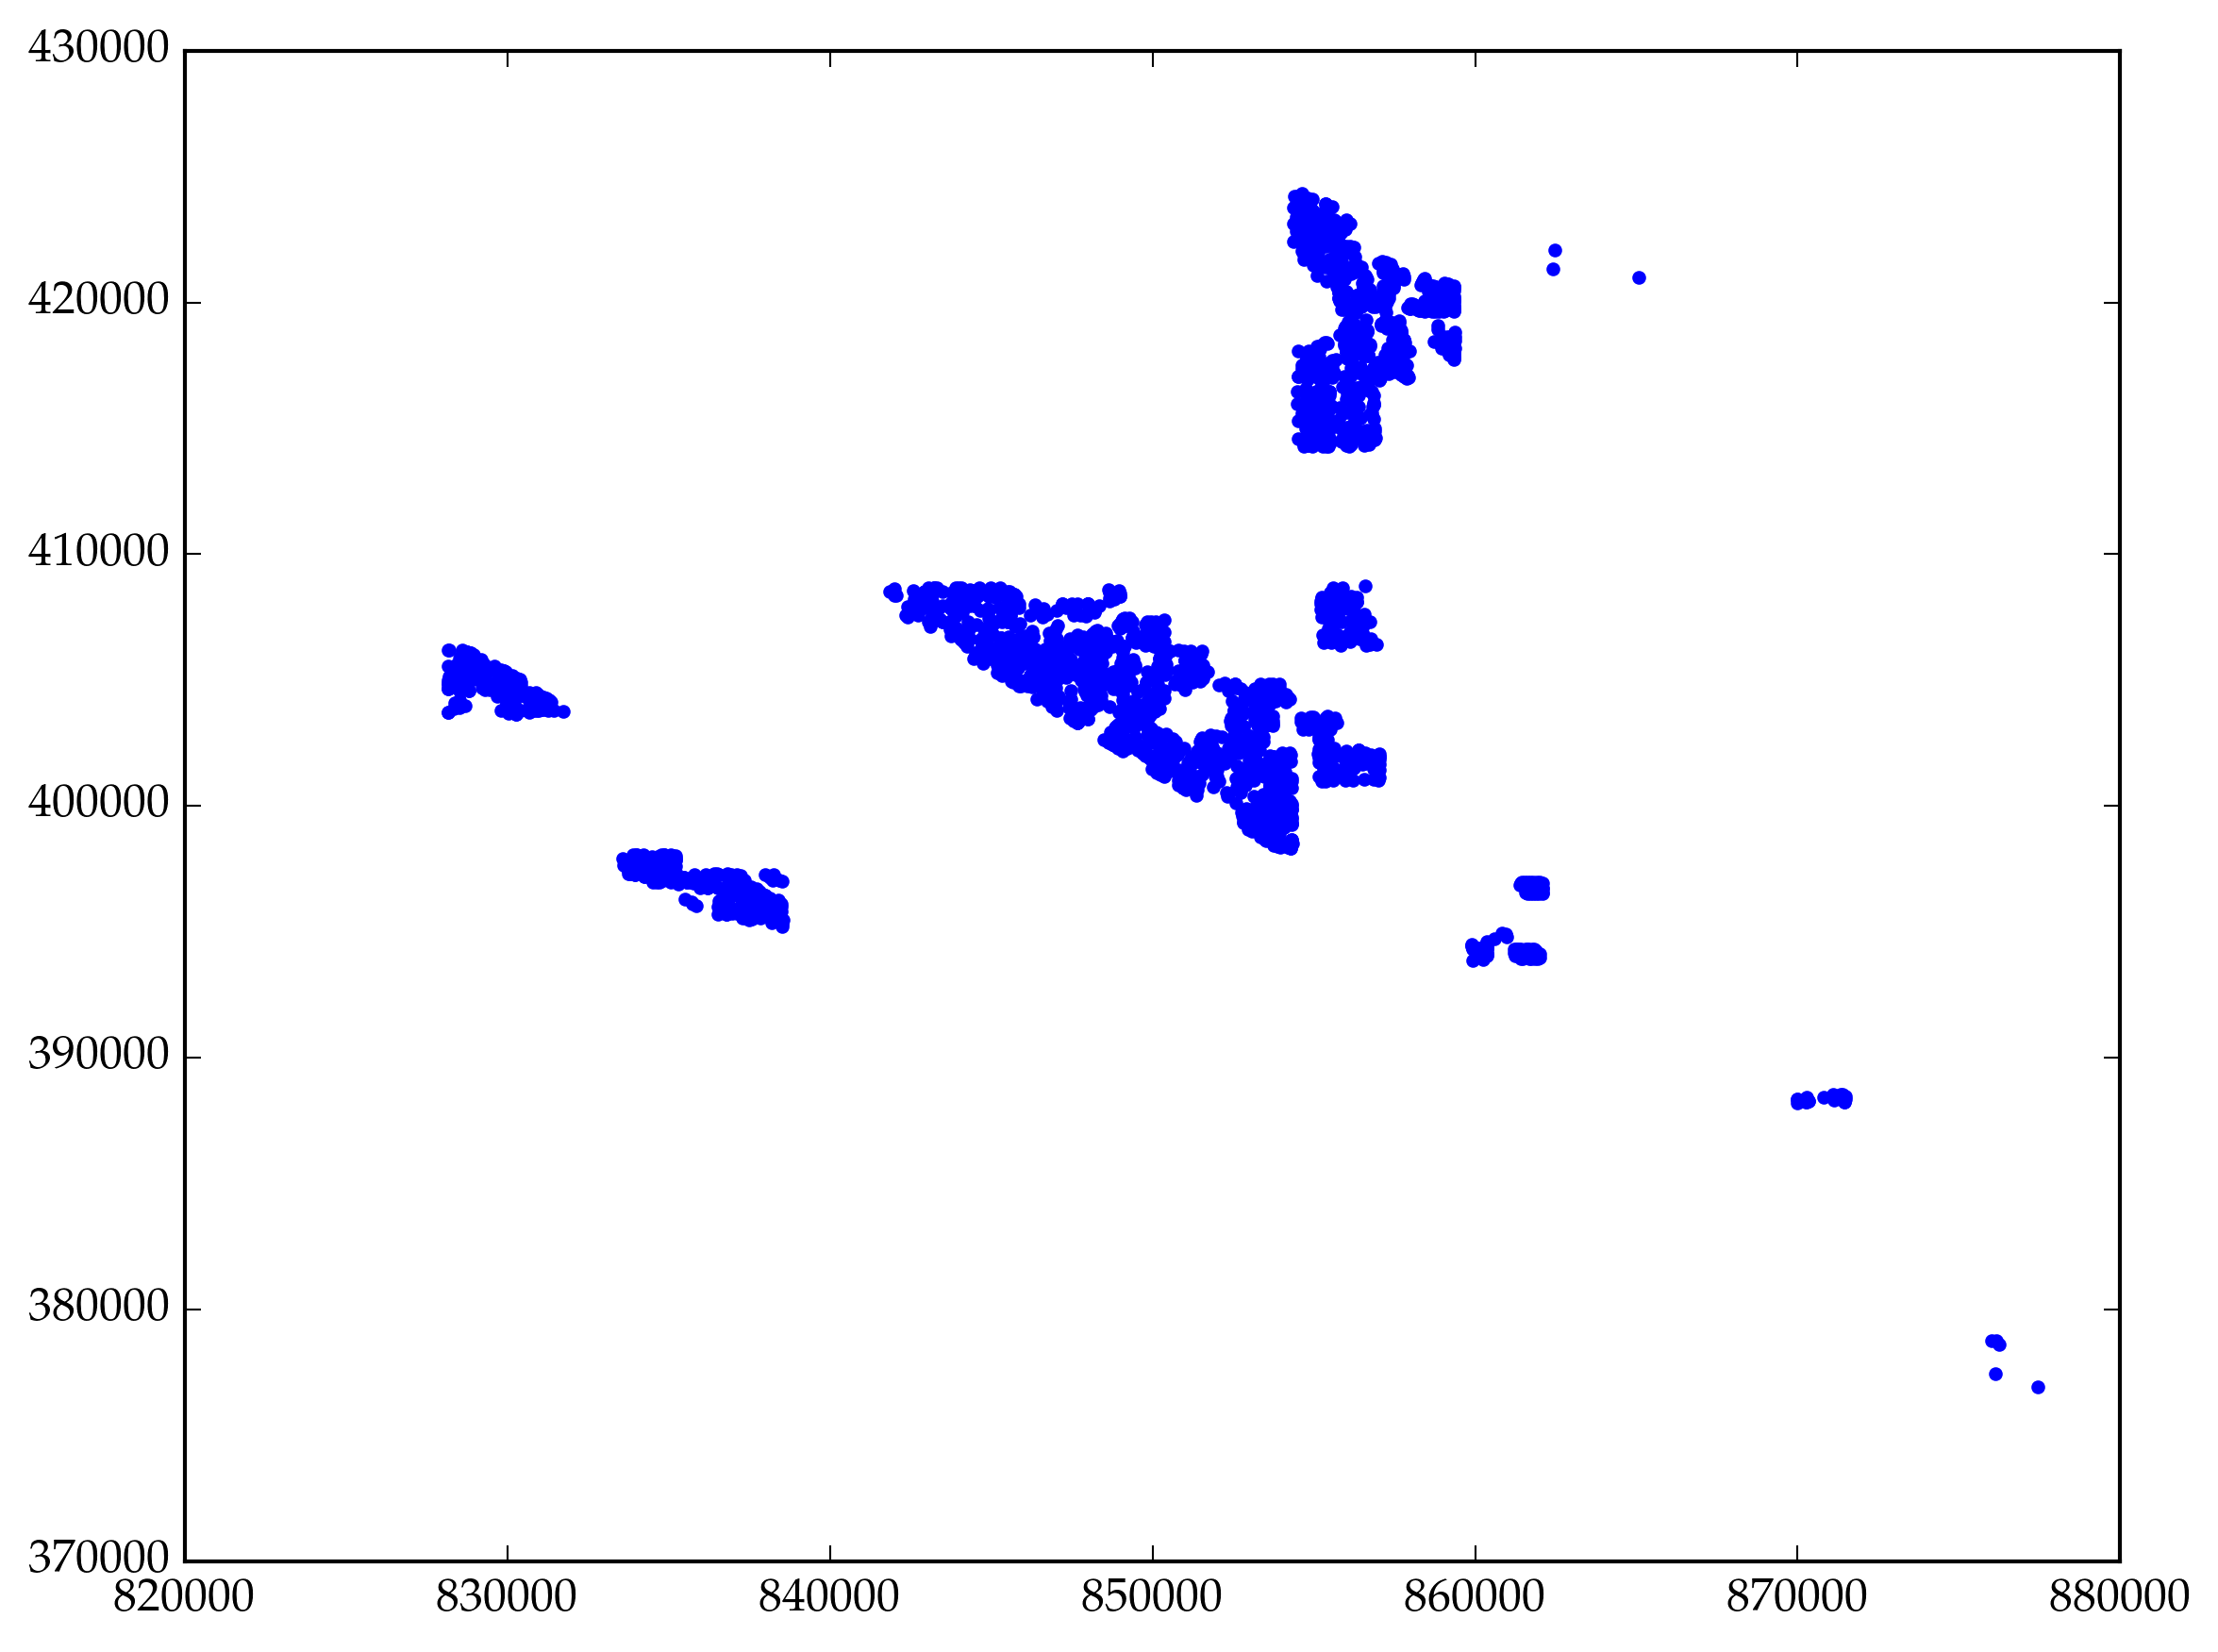

/Users/imolk/bin/venv_jupyter/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x31e247410>

In [9]:
plt.plot(X_dict["Vail Unified District"][:,1], X_dict["Vail Unified District"][:,2], ".")

In [10]:
std(X_dict["Vail Unified District"],1)

1x2 Array{Float64,2}:
 8831.95  8553.35

In [11]:
std(Y_dict["Vail Unified District"],1)

1-element Array{Float64,1}:
 0.306383

## Boundaries

In [12]:
sentinels_json=GeoJSON.parsefile("Tucson_data/processed/SchoolDistrict_borders/SchoolDistrict_sentinels.json")
;

In [13]:
sentinels_json.features[1].geometry

GeoJSON.MultiPoint([[787778.4481149958,455984.5341643696],[787751.0865443938,456397.6698585751],[787749.5781172435,456812.8333104904],[787745.7609360296,457227.9974193714],[787739.4065910273,457643.1370777555],[787735.2310601263,458058.3067060452],[787733.2446003554,458473.48214729567],[787730.4144609333,458888.6513425225],[787723.2484005521,459303.7800677075],[787714.9517681954,459718.8883934101]  …  [774413.2665882893,483965.60216168914],[774419.9755080368,484380.7132384444],[774408.9251022419,484795.6946818855],[774394.2752866163,485210.62389735965],[774379.9567833405,485625.5680679589],[774365.642725977,486040.51255899627],[774351.1690942488,486455.45150267304],[774329.0811134004,486870.0242033865],[774266.8216665802,487280.4599729624],[774095.8863404287,487562.1370055481]],#undef,#undef)

In [14]:
sentinels_json.features[1].properties

Dict{UTF8String,Any} with 2 entries:
  "SchoolDistrict2" => "Flowing Wells Unified District"
  "SchoolDistrict1" => "Amphitheater Unified District"

In [15]:
sentinels=Dict{Tuple{UTF8String,UTF8String},GeoJSON.MultiPoint}()
for f in sentinels_json.features
    key = (f.properties["SchoolDistrict1"], f.properties["SchoolDistrict2"])
    sentinels[key] = f.geometry
end

In [16]:
sentinels

Dict{Tuple{UTF8String,UTF8String},GeoJSON.MultiPoint} with 20 entries:
  ("Vail Unified District… => GeoJSON.MultiPoint([[827838.9234102826,424598.640…
  ("Sunnyside Unified Dis… => GeoJSON.MultiPoint([[732616.9915119059,402400.328…
  ("Flowing Wells Unified… => GeoJSON.MultiPoint([[787778.4481149958,455984.534…
  ("Vail Unified District… => GeoJSON.MultiPoint([[827978.8141461494,376356.671…
  ("Tucson Unified Distri… => GeoJSON.MultiPoint([[800840.1244605089,468987.397…
  ("Tanque Verde Unified … => GeoJSON.MultiPoint([[891423.8112493764,424978.648…
  ("Tucson Unified Distri… => GeoJSON.MultiPoint([[853566.3010435958,477957.228…
  ("Sunnyside Unified Dis… => GeoJSON.MultiPoint([[716932.1348773959,391746.233…
  ("Tanque Verde Unified … => GeoJSON.MultiPoint([[853566.3010435958,477957.228…
  ("Vail Unified District… => GeoJSON.MultiPoint([[891423.8112493764,424978.648…
  ("Tucson Unified Distri… => GeoJSON.MultiPoint([[787778.4481149958,455984.534…
  ("Amphitheater Unified … => GeoJSON.

# Model with fixed hyperparameters
## Fit GPs for each district

Fitting the hyperparameters is a whole other difficult issue. Let's skip ahead, plug in some arbitrary values, and come back to it later.

In [17]:
GP_dict=Dict{UTF8String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = X_dict[name]
    Y = Y_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    GP_dict[name] = fit
end

In [18]:
delete!(GP_dict, "Tanque Verde Unified District")

Dict{UTF8String,GaussianProcesses.GP{MT<:GaussianProcesses.Mean,KT<:GaussianProcesses.Kernel}} with 5 entries:
  "Flowing Wells Unified … => GP object:…
  "Amphitheater Unified D… => GP object:…
  "Sunnyside Unified Dist… => GP object:…
  "Vail Unified District"  => GP object:…
  "Tucson Unified Distric… => GP object:…

## 2GP posterior

In [19]:
distr1 = "Amphitheater Unified District"
distr2 = "Tucson Unified District"

"Tucson Unified District"

In [20]:
X◫ = hcat(sentinels[distr1,distr2].coordinates...)

2x100 Array{Float64,2}:
 8.0084e5   8.00848e5  8.0085e5   …  7.88304e5  7.88041e5  7.87778e5
 4.68987e5  4.68725e5  4.68462e5     4.55982e5  4.55983e5  4.55985e5

In [21]:
pred_1 = GaussianProcesses.predict(GP_dict[distr1], X◫; full_cov=true)
pred_2 = GaussianProcesses.predict(GP_dict[distr2], X◫; full_cov=true)
;

In [22]:
μposterior = pred_1[1].-pred_2[1]
Σposterior = pred_1[2]+pred_2[2]
;

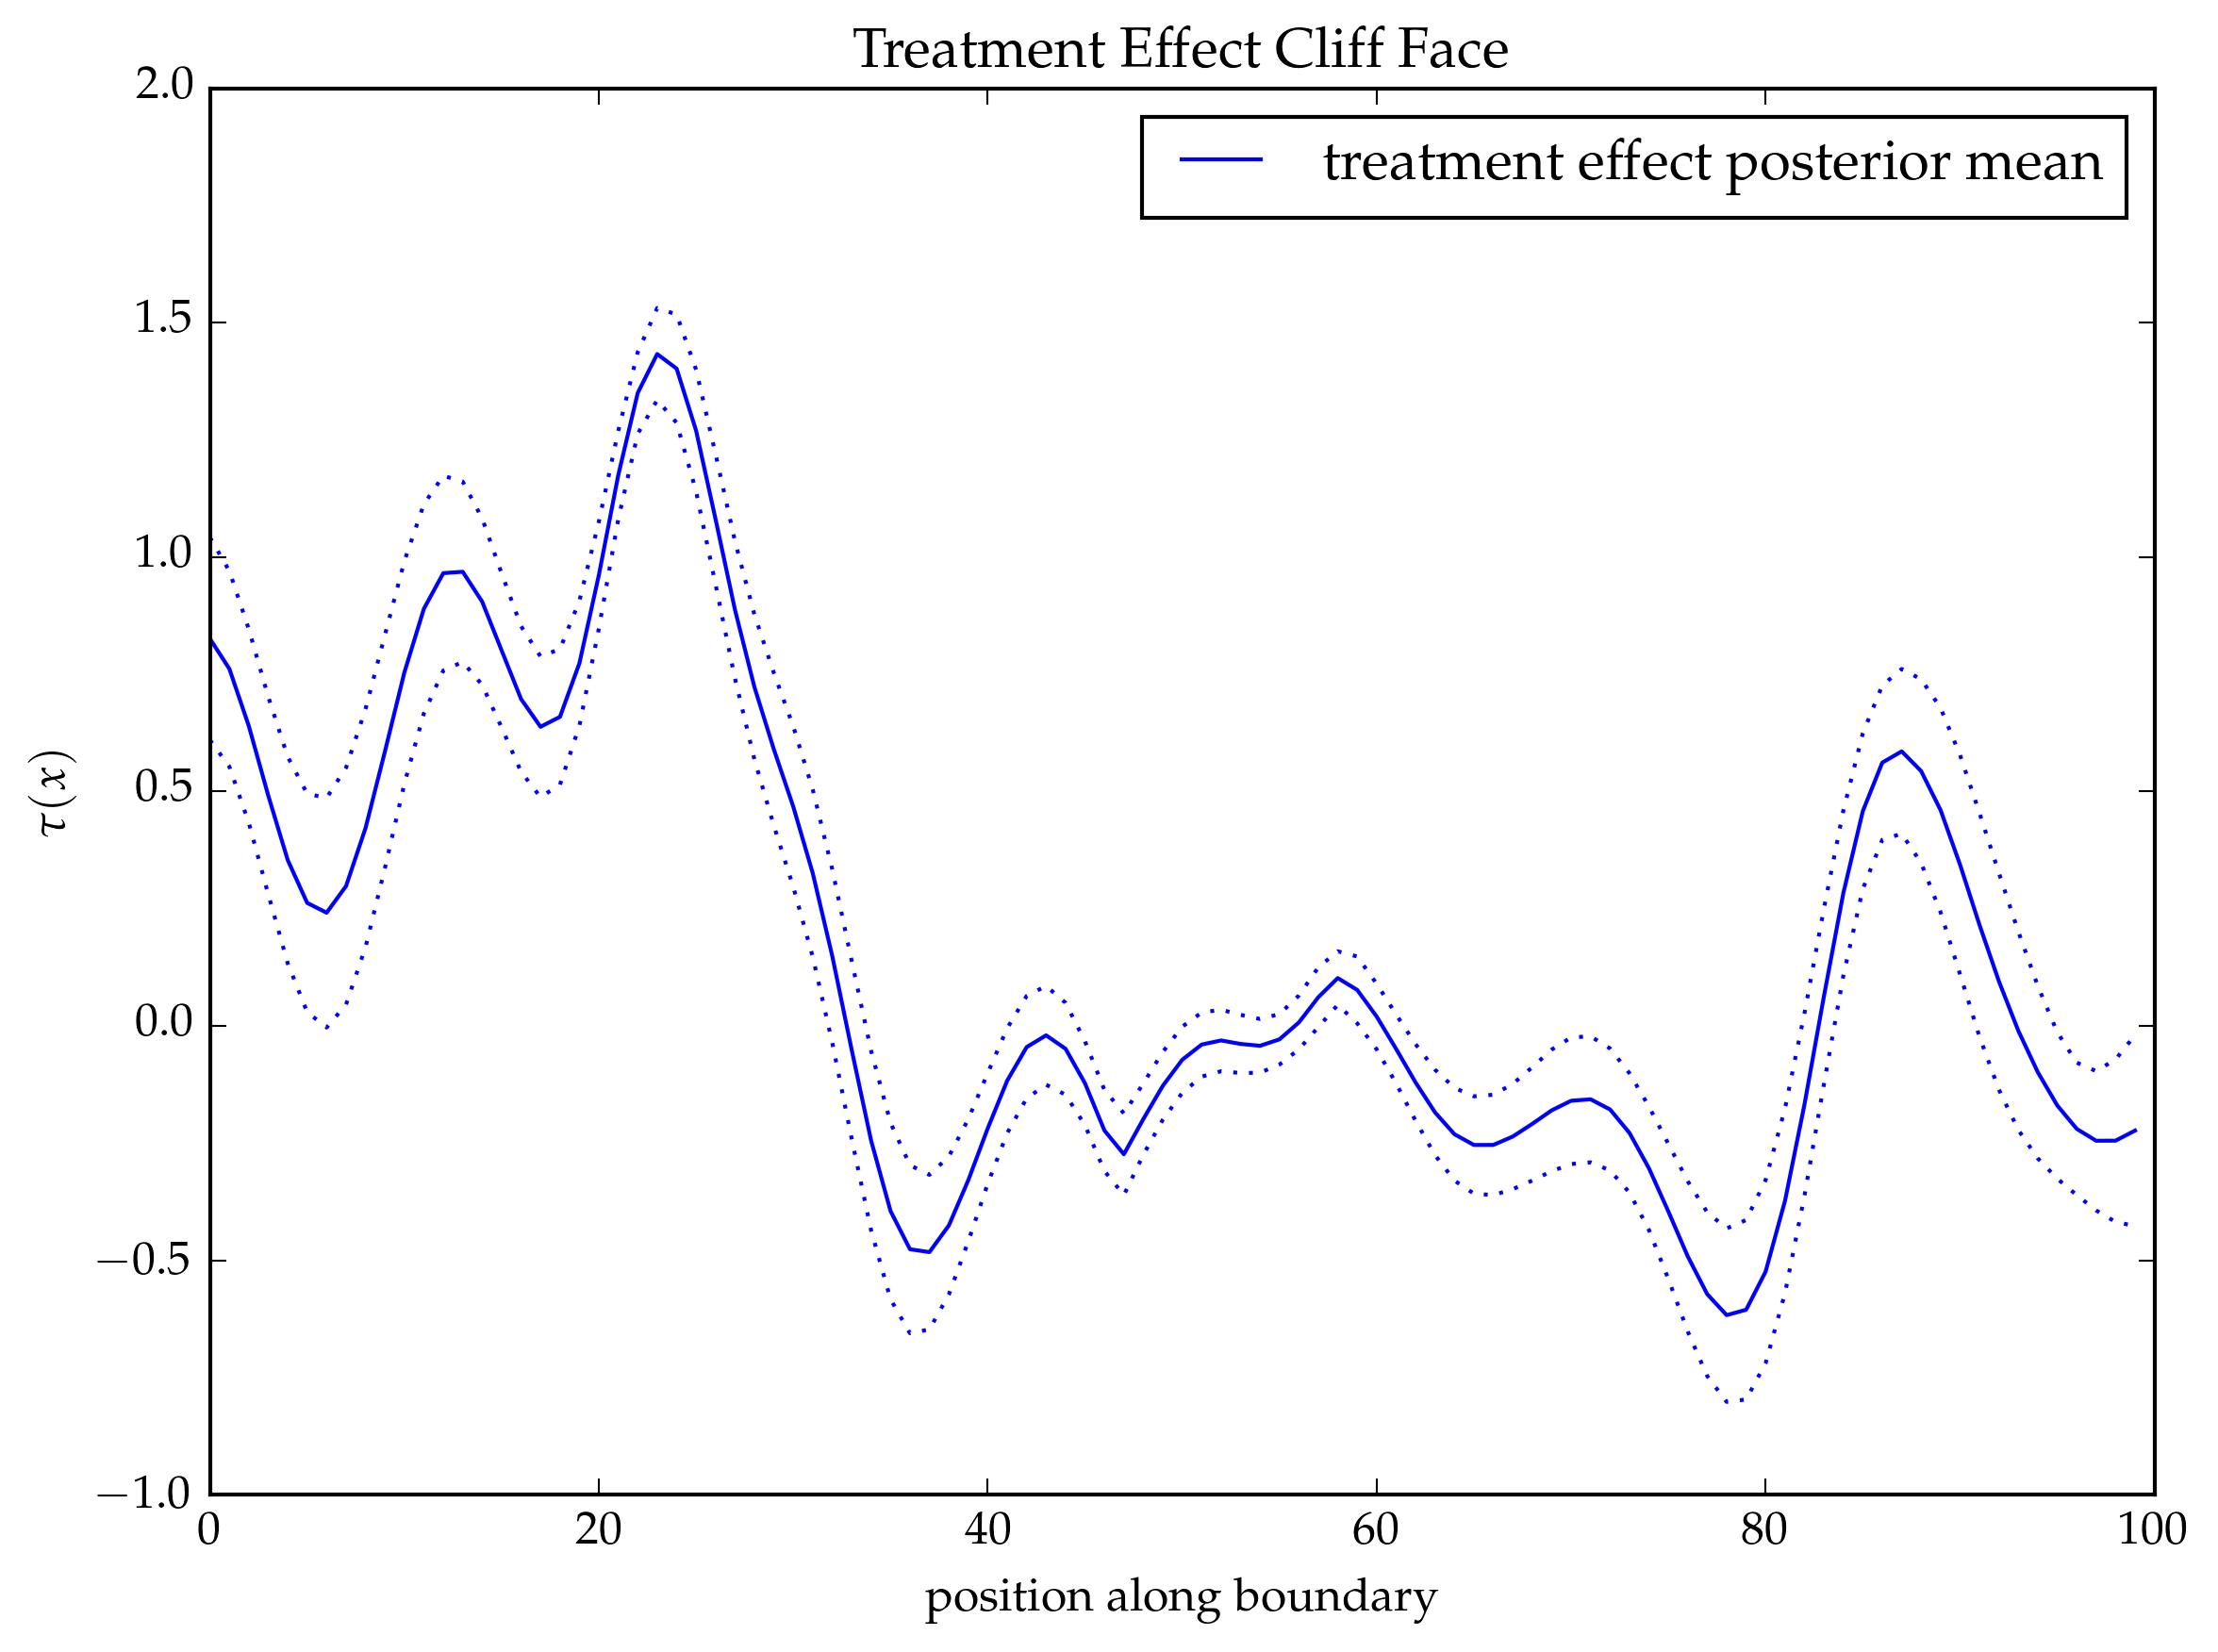

In [23]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
# plt.axhline(y=0, color="black")
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

## Inverse-Variance

In [24]:
n◫ = size(X◫)[2]

100

In [25]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal(μ=0.1452447318908475, σ=0.02734002304962643)

# Incorporating covariates

## Linear regression ignoring spatial correlation

In [26]:
Tucson_sales[:logSalePrice] = log(Tucson_sales[:SalePrice]);

In [27]:
Tucson_lm = lm(logSalePrice ~ SQFT + SchDistr + COOL + HEAT + WALLS + QUALITY + ROOMS + STORIES + CLASS + ROOF + GARAGE, Tucson_sales[believable,:])

DataFrames.DataFrameRegressionModel{GLM.LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredQR{Float64}},Float64}

Formula: logSalePrice ~ 1 + SQFT + SchDistr + COOL + HEAT + WALLS + QUALITY + ROOMS + STORIES + CLASS + ROOF + GARAGE

Coefficients:
                                              Estimate   Std.Error    t value Pr(>|t|)
(Intercept)                                    10.9301    0.113186    96.5678   <1e-99
SQFT                                       0.000434695  4.73121e-6    91.8783   <1e-99
SchDistr - Flowing Wells Unified District    -0.177112   0.0245984   -7.20015   <1e-12
SchDistr - Sunnyside Unified District        -0.323052   0.0116644   -27.6955   <1e-99
SchDistr - Tanque Verde Unified District     0.0876644    0.100793   0.869748   0.3844
SchDistr - Tucson Unified District          -0.0271874  0.00954664   -2.84785   0.0044
SchDistr - Vail Unified District            -0.0866852   0.0115587   -7.49959   <1e-13
COOL - None                                   0.418121

In [28]:
lm_coef_dict=Dict(zip(coefnames(Tucson_lm.mf), coef(Tucson_lm)))

Dict{UTF8String,Float64} with 47 entries:
  "HEAT - None"            => -0.0662947611033622
  "ROOMS"                  => 7.275824928416665e-6
  "CLASS - R-5"            => 1.0174697578783685
  "HEAT - Wall Furnance"   => -0.021451841704972826
  "ROOF - Slate"           => 0.11079177762469747
  "COOL - None"            => 0.41812138231252843
  "SchDistr - Tucson Unif… => -0.027187407983036163
  "QUALITY - Good"         => -0.17227635393662394
  "SchDistr - Sunnyside U… => -0.32305180923631444
  "WALLS - Framed Wood"    => 0.03880357647022802
  "CLASS - R-4"            => 0.8401322023750638
  "HEAT - Floor Furnance"  => 0.15664482757826345
  "HEAT - Radiant"         => 0.170820721522708
  "HEAT - Forced"          => 0.028498819274373966
  "SchDistr - Flowing Wel… => -0.1771124517731618
  "WALLS - Framed Block"   => 0.05563922154959083
  "SchDistr - Vail Unifie… => -0.08668524085834281
  "WALLS - 8 inch Stucco"  => 0.17780981056492645
  "COOL - Wall"            => 0.02891580924045186
  "

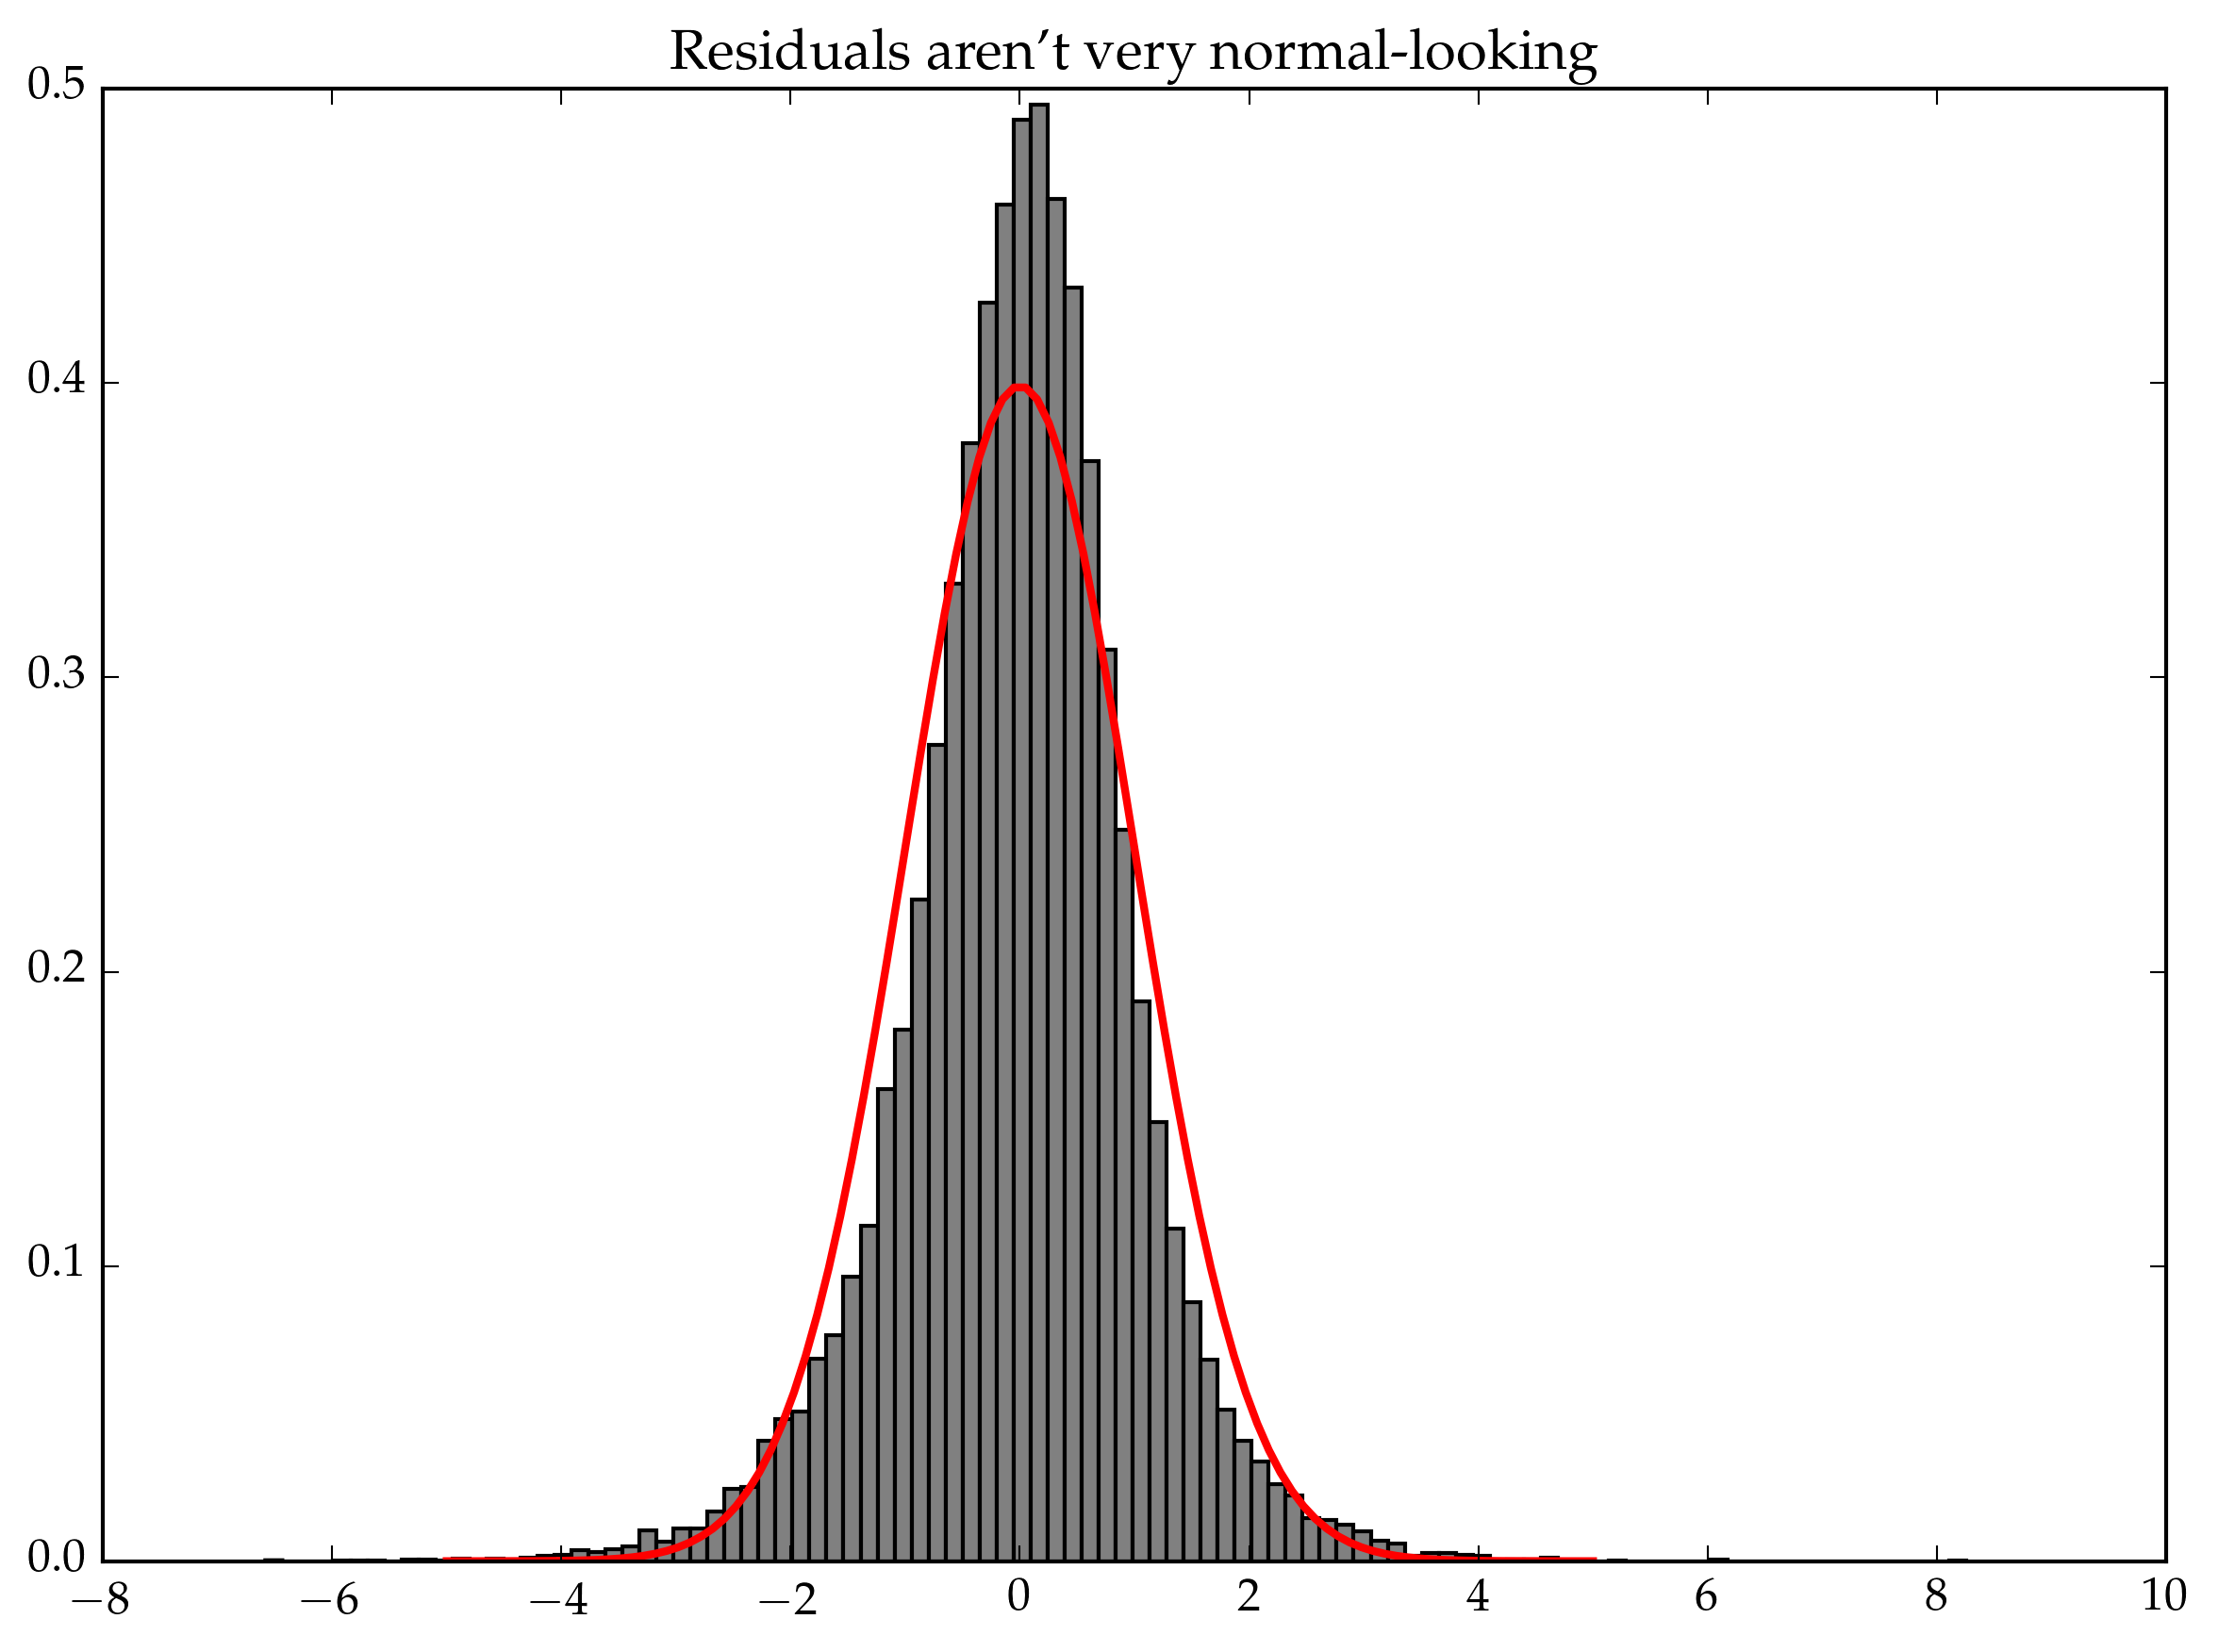

In [29]:
lm_residuals=residuals(Tucson_lm)
plt.plt[:hist](lm_residuals/std(lm_residuals),bins=100, normed=true, color="grey")
plt.plot(linspace(-5,5,100), pdf(Normal(), linspace(-5,5,100)), color="red", linewidth=2)
plt.title("Residuals aren't very normal-looking")
;

## Ridge regression

In [30]:
ridge_Y = convert(Vector{Float64}, Tucson_lm.mf.df[:logSalePrice])
ridge_coef=mvst.ridge(Tucson_lm.mm.m, ridge_Y, 100.0, bias=false)

47-element Array{Float64,1}:
  5.08144    
  0.000678735
  0.136687   
  0.100319   
  0.0453847  
  0.38712    
  0.287513   
  0.0512972  
  0.117078   
  0.268997   
  0.695127   
  1.52598    
  0.192071   
  ⋮          
 -0.014718   
  0.572685   
  0.599593   
  0.47445    
  0.242444   
  0.767261   
  0.020086   
  0.569932   
  0.510141   
  0.13107    
  0.137581   
  0.0757852  

In [31]:
ridge_coef_dict=Dict(zip(coefnames(Tucson_lm.mf), ridge_coef))

Dict{UTF8String,Float64} with 47 entries:
  "HEAT - None"            => 0.17702891707508395
  "ROOMS"                  => -0.0013953220903205072
  "CLASS - R-5"            => 0.8677481989260335
  "HEAT - Wall Furnance"   => 1.3318315265329914
  "ROOF - Slate"           => 0.02008597572078451
  "COOL - None"            => 0.05129722211150158
  "SchDistr - Tucson Unif… => 0.38712048004560445
  "QUALITY - Good"         => 1.590033591782739
  "SchDistr - Sunnyside U… => 0.10031906387001903
  "WALLS - Framed Wood"    => 0.15083723177004288
  "CLASS - R-4"            => 1.465940564698532
  "HEAT - Floor Furnance"  => 0.6951274289056103
  "HEAT - Radiant"         => 0.08300105963001647
  "HEAT - Forced"          => 1.5259799988581246
  "SchDistr - Flowing Wel… => 0.13668658172699089
  "WALLS - Framed Block"   => 0.06592487223078637
  "SchDistr - Vail Unifie… => 0.28751257884943704
  "WALLS - 8 inch Stucco"  => 0.3359010830208499
  "COOL - Wall"            => 0.26899687209702167
  "QUALITY - F

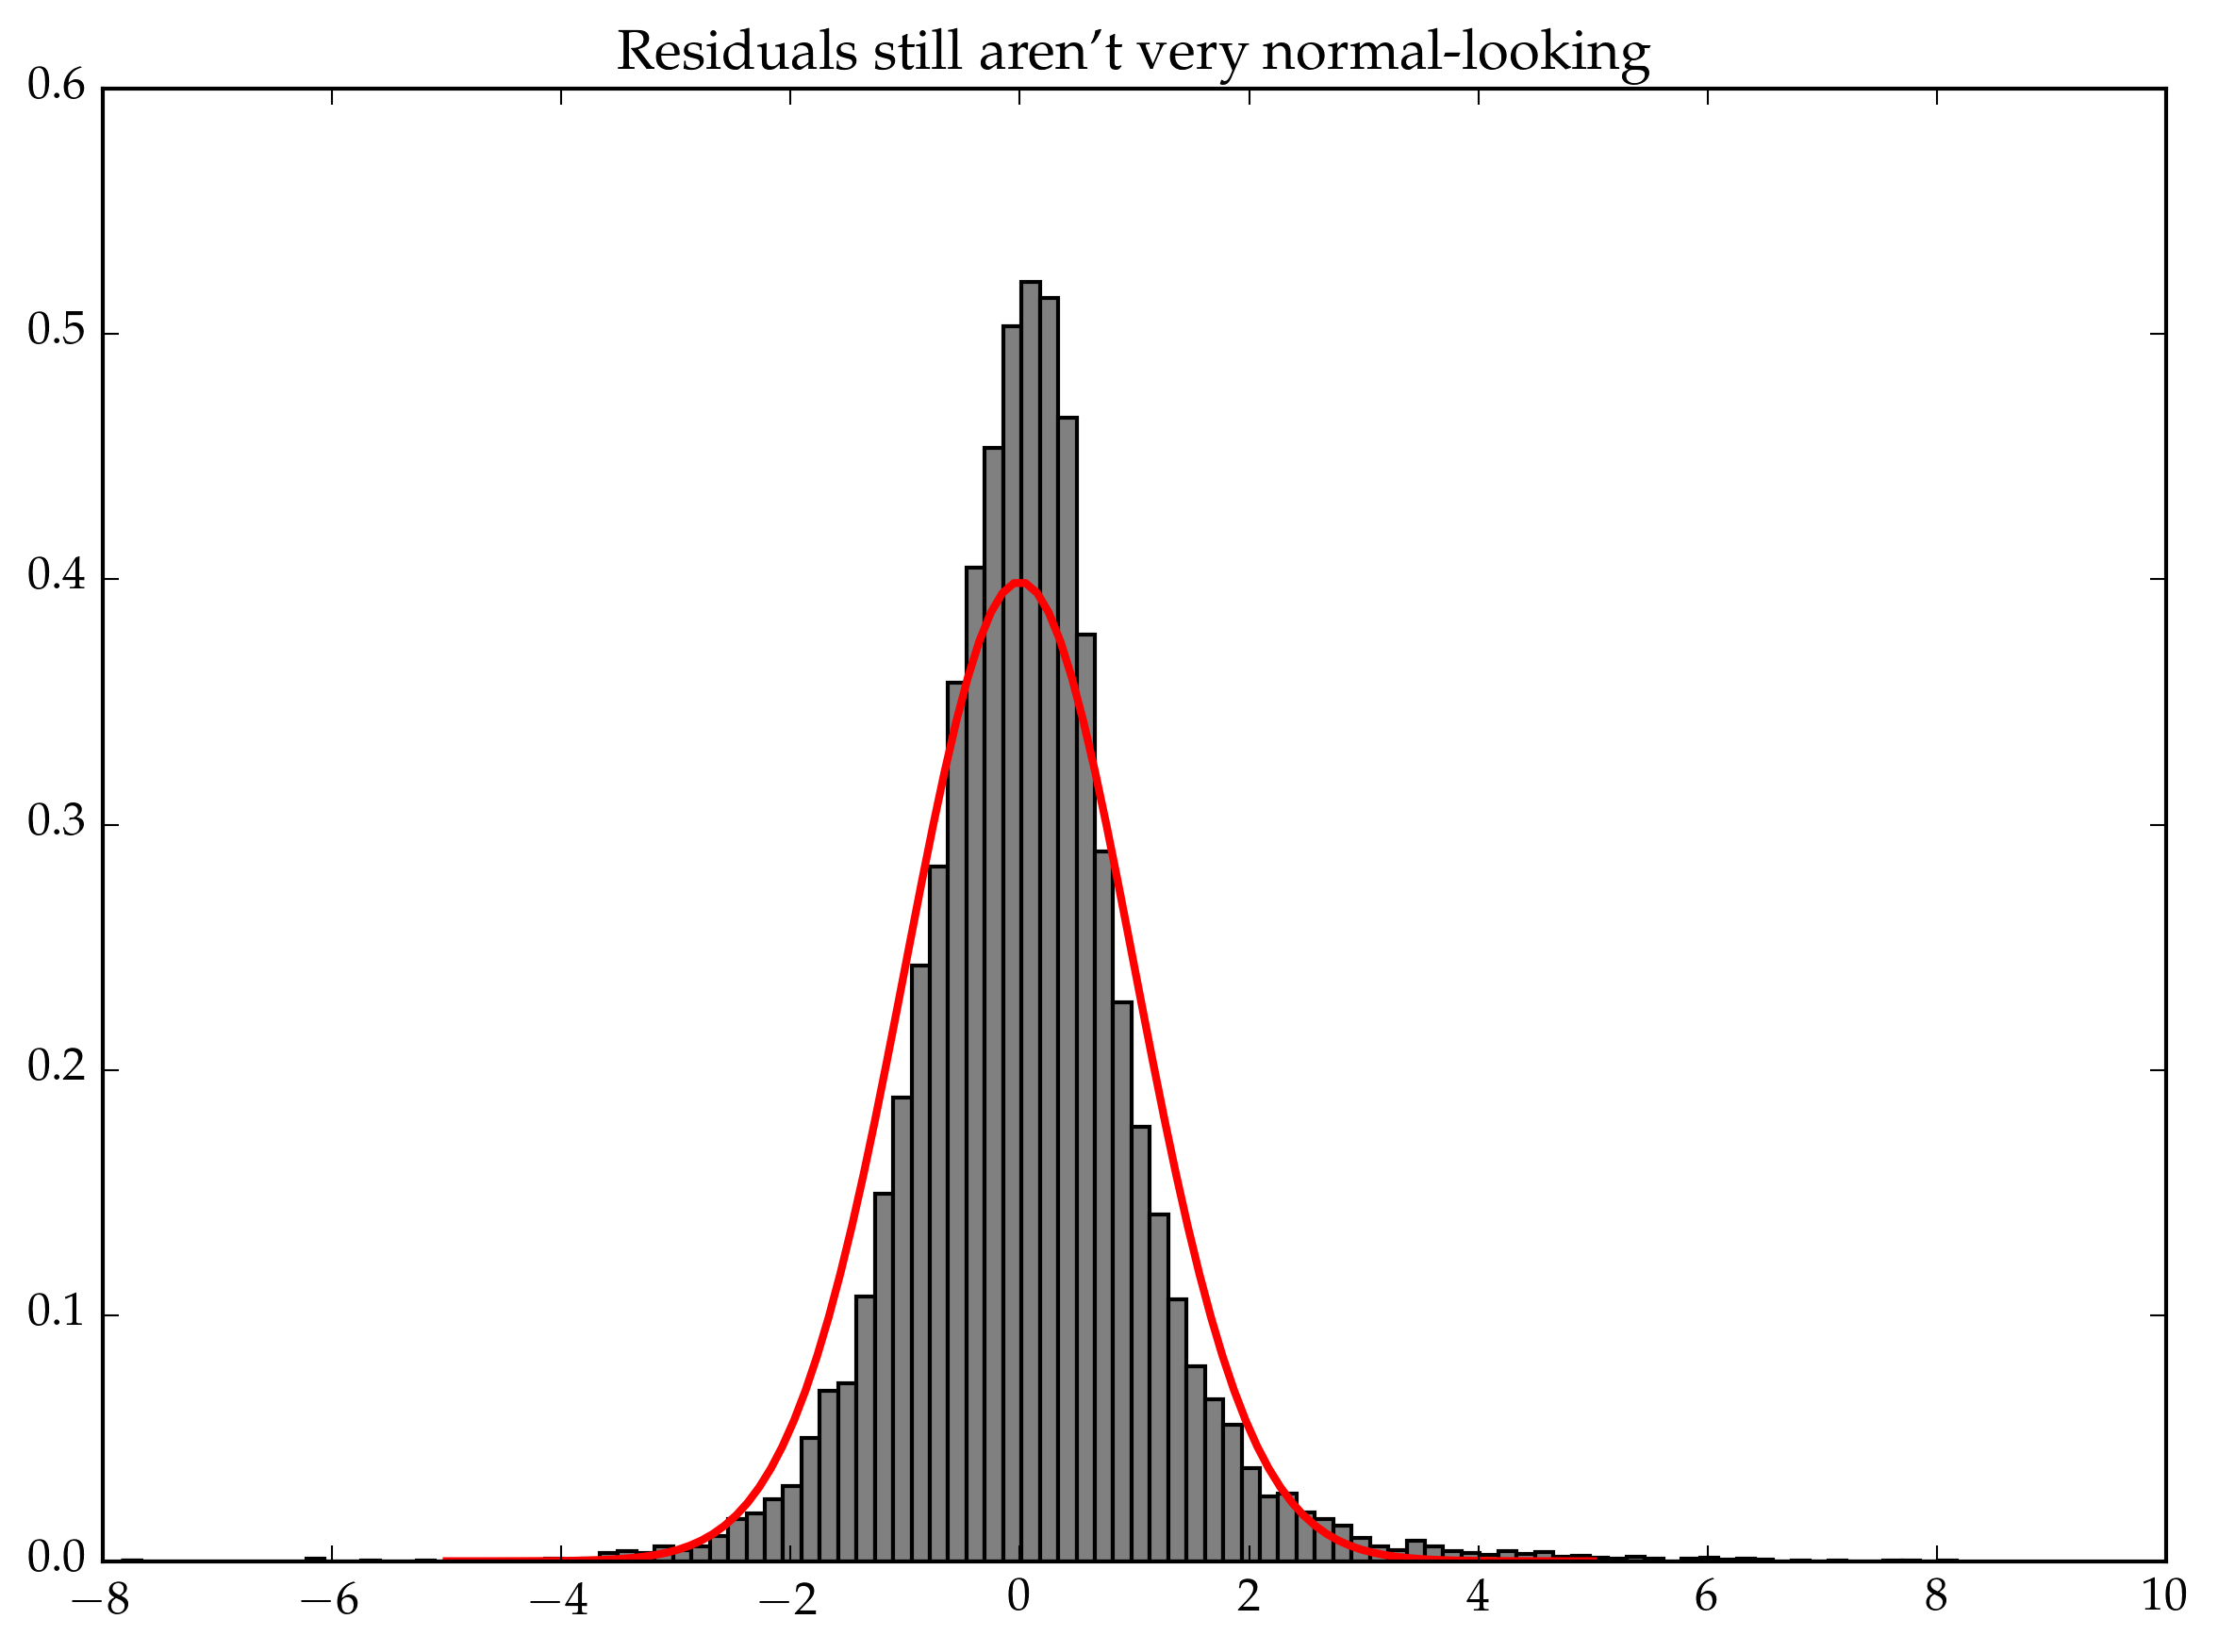

In [32]:
ridge_pred = Tucson_lm.mm.m * ridge_coef
ridge_resid = ridge_Y  .- ridge_pred
plt.plt[:hist](ridge_resid/std(ridge_resid),bins=100, normed=true, color="grey")
plt.plot(linspace(-5,5,100), pdf(Normal(), linspace(-5,5,100)), color="red", linewidth=2)
plt.title("Residuals still aren't very normal-looking")
;

## Fitting GPs to residuals

In [33]:
resid_dict=Dict{UTF8String, Vector{Float64}}()
recent_lm_resid_dict=Dict{UTF8String, Vector{Float64}}()
for name in schdistrs
    schdistr_coef = get(lm_coef_dict, "SchDistr - "name, 0.0)
    resid_dict[name] = lm_residuals[Tucson_sales[believable,:][:SchDistr] .== name] + schdistr_coef
    recent_lm_resid_dict[name] = lm_residuals[recent_in_believable & (Tucson_sales[believable,:][:SchDistr] .== name)] + schdistr_coef
end
ridge_resid_dict=Dict{UTF8String, Vector{Float64}}()
recent_ridge_resid_dict=Dict{UTF8String, Vector{Float64}}()
for name in schdistrs
    schdistr_coef = get(ridge_coef_dict, "SchDistr - "name, 0.0)
    ridge_resid_dict[name] = ridge_resid[Tucson_sales[believable,:][:SchDistr] .== name] + schdistr_coef
    recent_ridge_resid_dict[name] = ridge_resid[recent_in_believable & (Tucson_sales[believable,:][:SchDistr] .== name)] + schdistr_coef
end

In [34]:
resid_GP_dict=Dict{UTF8String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = X_dict[name]
    Y = resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    resid_GP_dict[name] = fit
end

In [35]:
resid_pred_1 = GaussianProcesses.predict(resid_GP_dict[distr1], X◫; full_cov=true)
resid_pred_2 = GaussianProcesses.predict(resid_GP_dict[distr2], X◫; full_cov=true)
;

In [36]:
resid_μposterior = resid_pred_1[1].-resid_pred_2[1]
resid_Σposterior = resid_pred_1[2]+resid_pred_2[2]
;

In [37]:
ridge_GP_dict=Dict{UTF8String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = X_dict[name]
    Y = ridge_resid_dict[name]
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    ridge_GP_dict[name] = fit
end

In [38]:
ridge_pred_1 = GaussianProcesses.predict(ridge_GP_dict[distr1], X◫; full_cov=true)
ridge_pred_2 = GaussianProcesses.predict(ridge_GP_dict[distr2], X◫; full_cov=true)
;

In [39]:
ridge_μposterior = ridge_pred_1[1].-ridge_pred_2[1]
ridge_Σposterior = ridge_pred_1[2]+ridge_pred_2[2]
;

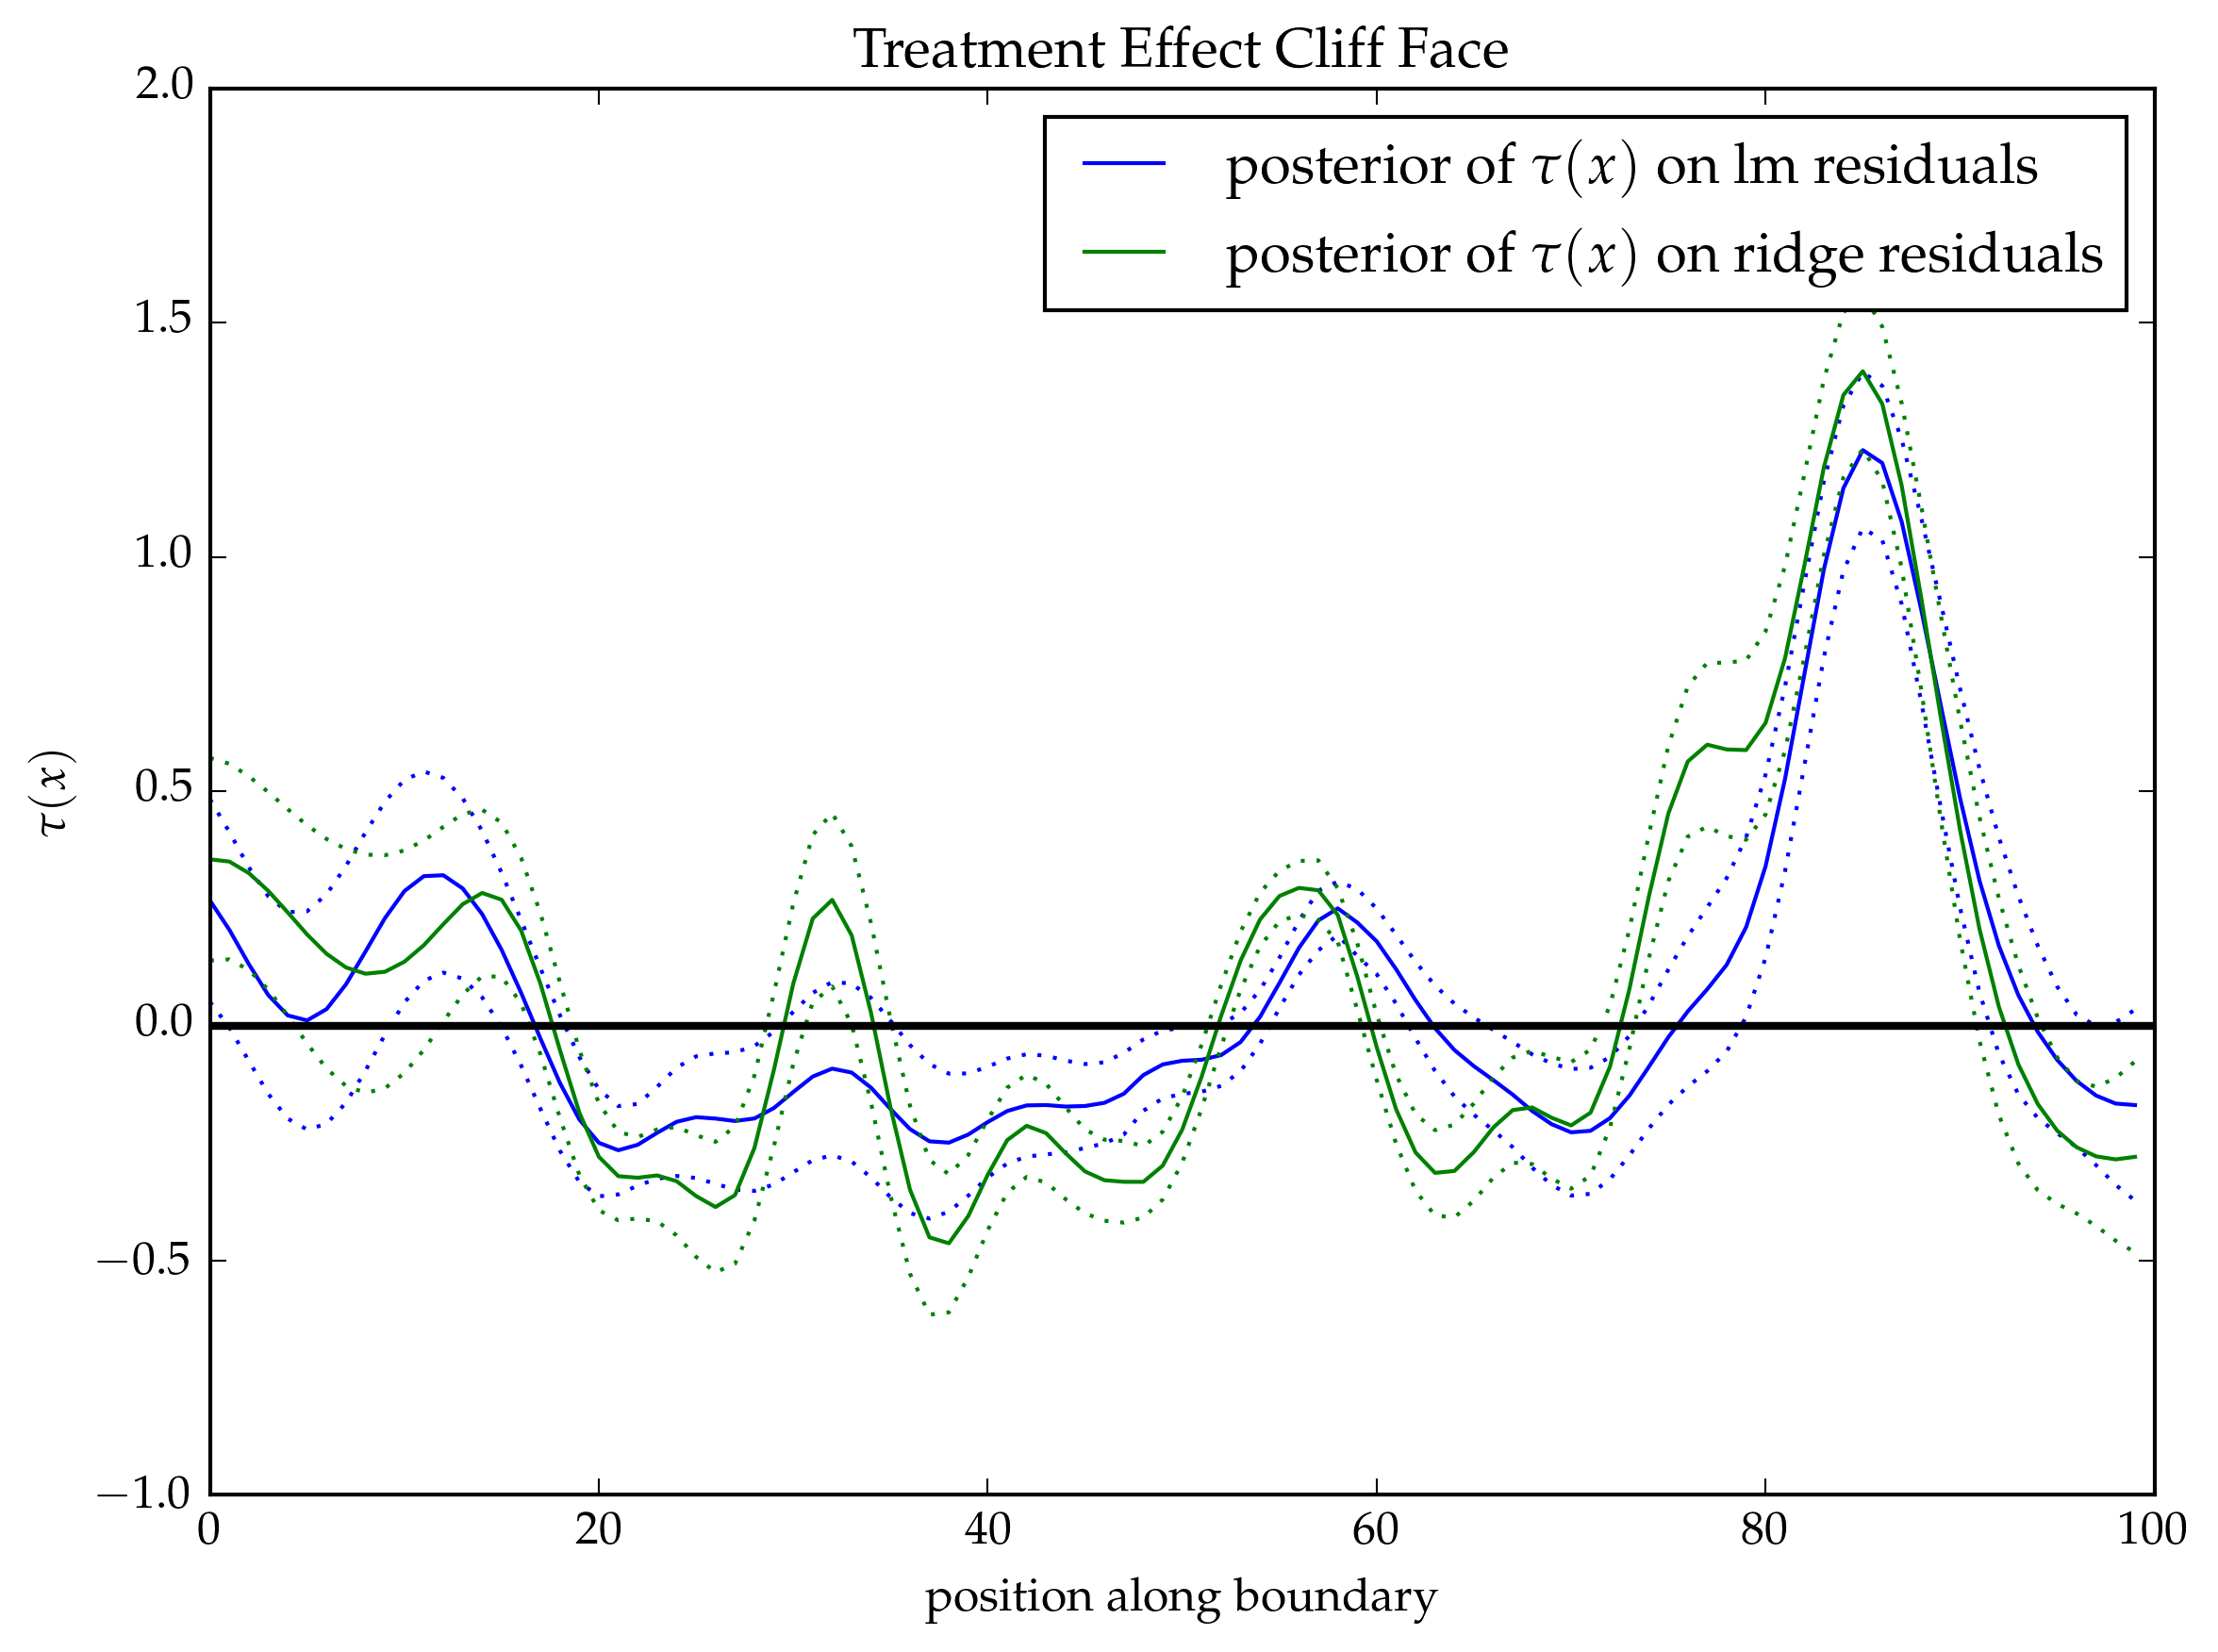

In [40]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(resid_μposterior, color="blue", label=L"posterior of $\tau(x)$ on lm residuals")
plt.plot(resid_μposterior.+√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(resid_μposterior.-√diag(resid_Σposterior), color="blue", linestyle=":")
plt.plot(ridge_μposterior, color="green", label=L"posterior of $\tau(x)$ on ridge residuals")
plt.plot(ridge_μposterior.+√diag(ridge_Σposterior), color="green", linestyle=":")
plt.plot(ridge_μposterior.-√diag(ridge_Σposterior), color="green", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

The treatment effect derived from the linear regression and ridge regression residuals are broadly in agreement. Troublingly, the sign of the treatment effect is not consistent along the boundary, which is difficult to explain. Our story is that one school district performs better than the other, and so house prices should increase or decrease discontinuously at the boundary. It doesn't make much sense for prices to increase on one side of the boundary, and decrease on the other.

# Hyperparameters

Now the difficult part. We need to fit the GP hyperparameters to the data.

In [41]:
typealias MultiGP Vector{GP}

Array{GaussianProcesses.GP{MT<:GaussianProcesses.Mean,KT<:GaussianProcesses.Kernel},1}

In [42]:
@doc """
# Description
A function for optimising the GP hyperparameters based on type II maximum likelihood estimation. This function performs gradient based optimisation using the Optim pacakge to which the user is referred to for further details.

# Arguments:
* `gps::MultiGP`: Vector of Gaussian Processes to fit with the same parameters
* `noise::Bool`: Noise hyperparameters should be optimized
* `mean::Bool`: Mean function hyperparameters should be optimized
* `kern::Bool`: Kernel function hyperparameters should be optimized
* `kwargs`: Keyword arguments for the optimize function from the Optim package
""" ->
function GaussianProcesses.optimize!(mgp::MultiGP; noise::Bool=true, mean::Bool=true, kern::Bool=true, method=ConjugateGradient(), kwargs...)
    function mll(hyp::Vector{Float64})
        mLL = 0.0
        println("mll setting parameters: ", hyp)
        try
            for gp in mgp
                GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
                GaussianProcesses.update_mll!(gp)
                mLL += gp.mLL
            end
        catch err
            if isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end  
        println("-mLL: ", -mLL)
        return -mLL
    end
    function dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        grad[:] = 0.0
        println("dmll setting parameters: ", hyp)
        for gp in mgp
            GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
            GaussianProcesses.update_mll_and_dmll!(gp; noise=noise, mean=mean, kern=kern)
            grad[:] -= gp.dmLL
        end
    end
    function mll_and_dmll!(hyp::Vector{Float64}, grad::Vector{Float64})
        grad[:] = 0.0
        mLL = 0.0
        println("mll_and_dmll setting parameters: ", hyp)
        try
            for gp in mgp
                GaussianProcesses.set_params!(gp, hyp; noise=noise, mean=mean, kern=kern)
                GaussianProcesses.update_mll_and_dmll!(gp; noise=noise, mean=mean, kern=kern)
                mLL += gp.mLL
                grad[:] -= gp.dmLL
            end
        catch err
            if isa(err, Base.LinAlg.PosDefException)
                println(err)
                return Inf
            else
                throw(err)
            end
        end
        println("-mLL: ", -mLL)
        return -mLL
    end

    func = DifferentiableFunction(mll, dmll!, mll_and_dmll!)
    init = GaussianProcesses.get_params(mgp[1];  noise=noise, mean=mean, kern=kern)  # Initial hyperparameter values
    println("initial parameters: ", init)
    results=optimize(func,init; method=method, kwargs...)                     # Run optimizer
    print(results)
end

optimize! (generic function with 2 methods)

In [43]:
recent_GP_dict=Dict{UTF8String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = recent_X_dict[name]
    Y = recent_Y_dict[name]
    if length(Y)==0
        continue
    end
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    recent_GP_dict[name] = fit
end
recent_multiGP = collect(values(recent_GP_dict))
init_params = GaussianProcesses.get_params(recent_multiGP[1])

LoadError: LoadError: MethodError: `get_params` has no method matching get_params(::Array{GaussianProcesses.GP{MT<:GaussianProcesses.Mean,KT<:GaussianProcesses.Kernel},1})
while loading In[43], in expression starting on line 16

In [44]:
@time hyp_fit=optimize!(recent_multiGP, 
    noise=true, mean=true, kern=true, 
    method=ConjugateGradient(), 
    show_trace=true, iterations=10);

initial parameters: [-2.3025850929940455,11.766598687771586,6.907755278982137,-1.6094379124341003]
Iter     Function value   Gradient norm 
mll_and_dmll setting parameters: [-2.3025850929940455,11.766598687771586,6.907755278982137,-1.6094379124341003]
-mLL: 5007.796277026526
     0     5.007796e+03     1.215710e+04
mll setting parameters: [2429.118145311176,447.7434857471163,-655.5147343201671,776.3978932474636]
-mLL: NaN
mll setting parameters: [240.83948794742295,55.364287393706064,-59.334493680932795,76.19129520355568]
Base.LinAlg.PosDefException(1501)
mll setting parameters: [22.011622211047655,16.126367558365033,0.2835303829906435,6.170635399164878]
-mLL: 122655.56942100628
mll_and_dmll setting parameters: [22.011622211047655,16.126367558365033,0.2835303829906435,6.170635399164878]
-mLL: 122655.56942100628
mll_and_dmll setting parameters: [15.523086297319393,14.962911290239123,2.051283721636766,4.0944301393143]
-mLL: 87948.39081878882
mll_and_dmll setting parameters: [6.6102506021

In [45]:
hyp_fit

In [46]:
gp=recent_GP_dict["Amphitheater Unified District"]

GP object:
  Dim = 2
  Number of observations = 237
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [11.945644543871166]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [7.011732794458648,-1.0041310679398927]
  Input observations = 
2x237 Array{Float64,2}:
 7.89133e5  7.89256e5  7.89195e5  7.89195e5  …  8.00693e5  8.00581e5
 4.66731e5  4.66887e5  4.66886e5  4.66886e5     4.56999e5  4.56996e5
  Output observations = [11.6527,11.4404,11.3851,11.3851,11.7118,12.5707,12.449,12.5172,12.4875,12.7657  …  12.2036,12.3842,12.2923,11.8845,11.8845,12.2429,11.835,12.1007,12.0436,12.0725]
  Variance of observation noise = 0.20917993606836205
  Marginal Log-Likelihood = -119.669

Great! The optimization took 13.5 minutes, which is perhaps reasonable. Now let's reset the GPs and optimize again with the LBFGS method instead of ConjugateGradient, to see if we get the same result, and which is faster.

In [57]:
for gp in recent_multiGP
    GaussianProcesses.set_params!(gp, init_params)
end

In [48]:
@time hyp_fit2=optimize!(recent_multiGP, 
    noise=true, mean=true, kern=true, 
    method=LBFGS(), 
    show_trace=true, iterations=10);

initial parameters: [-1.5645604592858444,11.945644543871166,7.011732794458648,-1.0041310679398927]
Iter     Function value   Gradient norm 
mll_and_dmll setting parameters: [-1.5645604592858444,11.945644543871166,7.011732794458648,-1.0041310679398927]
-mLL: 626.4973469076389
     0     6.264973e+02     4.177914e+00
mll_and_dmll setting parameters: [-5.742474163930411,11.550283028671194,5.797747955229904,0.9276302191615378]
-mLL: 152716.6862966742
mll_and_dmll setting parameters: [-1.564645296350037,11.945636515627259,7.011708143181236,-1.0040918414340565]
-mLL: 626.4969068371372
mll_and_dmll setting parameters: [-1.564645296350037,11.945636515627259,7.011708143181236,-1.0040918414340565]
-mLL: 626.4969068371372
     1     6.264969e+02     3.611841e+00
mll_and_dmll setting parameters: [-1.5646522218788836,11.94563009627622,7.011655013850982,-1.0040379705213902]
-mLL: 626.4967124210841
mll_and_dmll setting parameters: [-1.56467992399427,11.94560441887207,7.011442496529963,-1.003822486870

We reach the same parameter values, but it took a lot longer! We should stick with conjugate gradient descent.

In [49]:
gp=next(values(recent_GP_dict),1)[1]
k=gp.k
k.σ2, √(k.ℓ2)

(0.1345513758604861,1108.079223319545)

In [ ]:
for distr in schdistrs
    if !haskey(GP_dict, distr)
        continue
    end
    GaussianProcesses.set_params!(GP_dict[distr], GaussianProcesses.get_params(gp))
    GaussianProcesses.update_mll_and_dmll!(GP_dict[distr])
end

In [51]:
pred_1 = GaussianProcesses.predict(GP_dict[distr1], X◫; full_cov=true)
pred_2 = GaussianProcesses.predict(GP_dict[distr2], X◫; full_cov=true)
;

In [52]:
μposterior = pred_1[1].-pred_2[1]
Σposterior = pred_1[2]+pred_2[2]
;

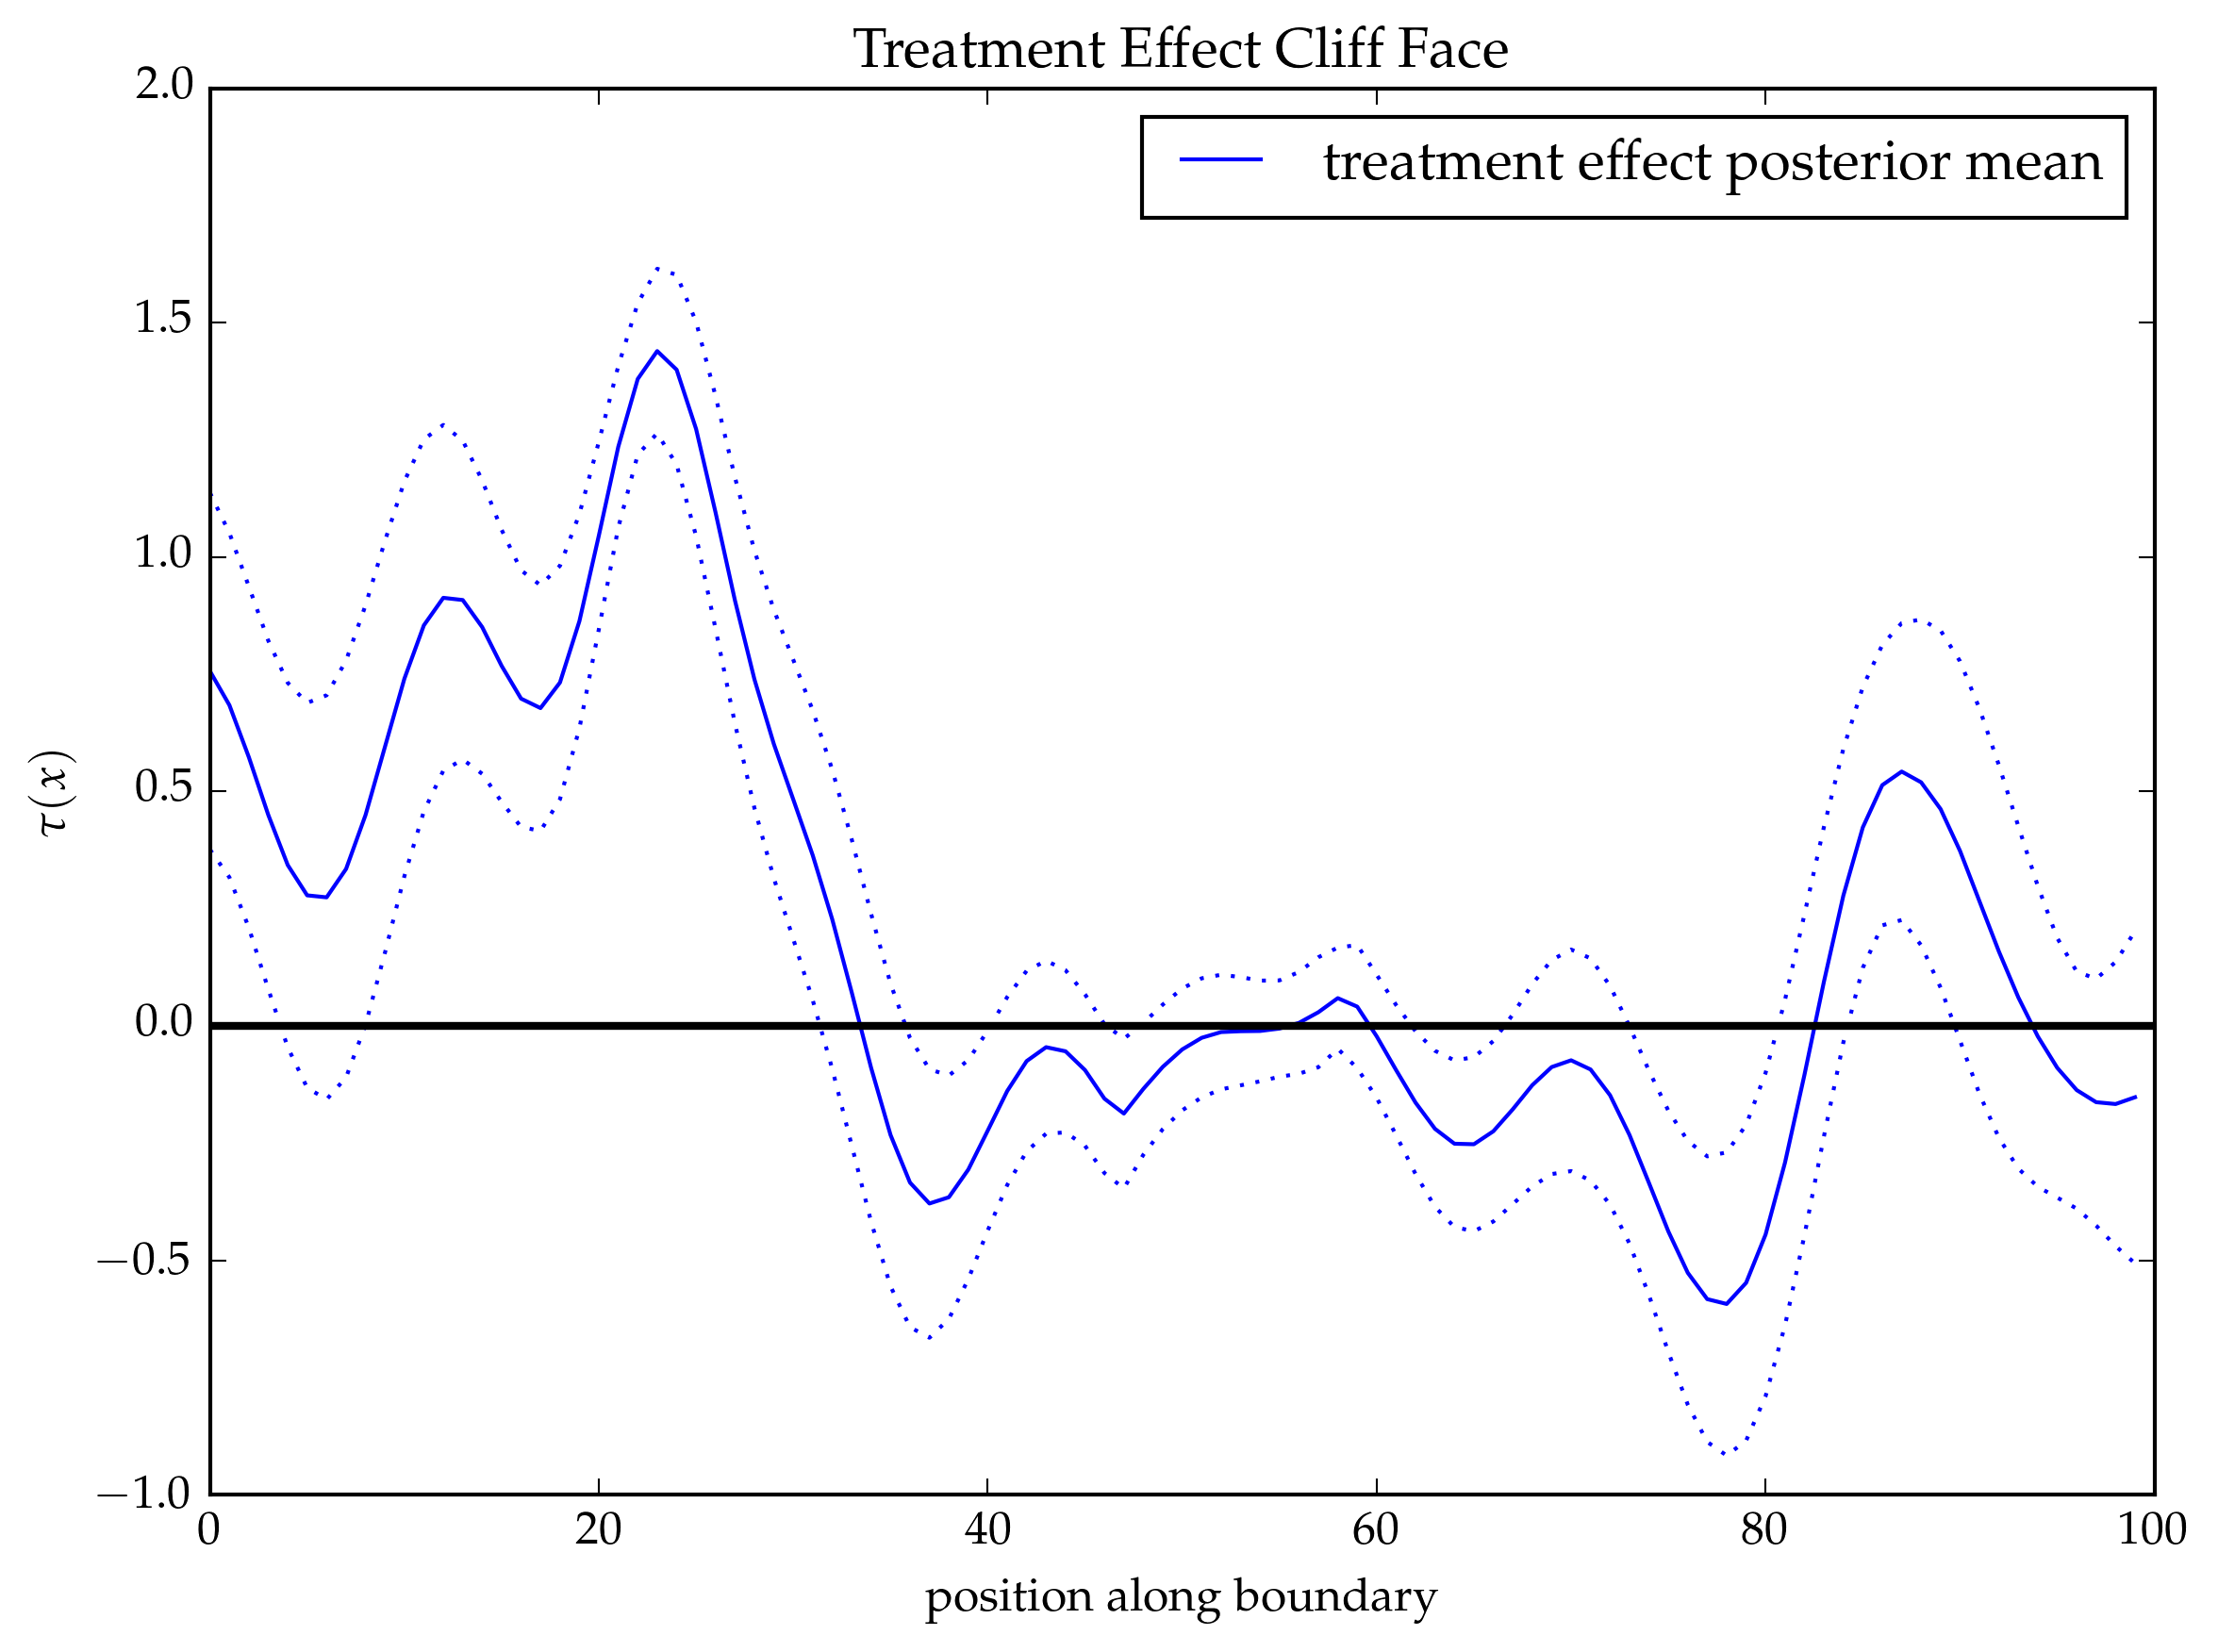

In [53]:
PyPlot.plt[:interactive](true)
plt.title("Treatment Effect Cliff Face")
PyPlot.plt[:interactive](false)
plt.plot(μposterior, color="blue", label="treatment effect posterior mean")
plt.plot(μposterior.+√diag(Σposterior), color="blue", linestyle=":")
plt.plot(μposterior.-√diag(Σposterior), color="blue", linestyle=":")
plt.axhline(y=0, color="black", linewidth=2)
# plt.axhline(y=2, color="darkmagenta", label="truth")
plt.ylabel(L"\tau(x)")
plt.xlabel("position along boundary")
plt.legend()
PyPlot.plt[:interactive](true)
;

In [54]:
denom_weighted = dot(ones(n◫),(Σposterior \ ones(n◫)))
τhat_weighted = sum(Σposterior\μposterior) / denom_weighted
Vτhat_weighted = 1/denom_weighted
Normal(τhat_weighted, √Vτhat_weighted)

Distributions.Normal(μ=0.15443676544261156, σ=0.052703307496966036)

This new value of the hyperparameters changes the inverse-variance-weighted mean somewhat, and its posterior standard deviation by a lot. This shows that the choice of hyperparameters is crucial for inference, and needs to be thought about very carefully. From an interpretation point of view, it's troubling that the posterior treatment effect goes from being positive to negative as we move along the school district boundary.

# Covariates and hyperparameters

## Fitting GP to ridge residuals

The simplest thing to do is to:
1. run a ridge regression
2. fit a GP to the residuals

In [55]:
recent_ridge_GP_dict=Dict{UTF8String, GP}()
σf = 0.2
σy = 0.1
L = 1000.0
kern = SEIso(log(L), log(σf))
for name in schdistrs
    X = recent_X_dict[name]
    Y = recent_ridge_resid_dict[name]
    if length(Y)==0
        continue
    end
    fit = GP(X', Y, MeanConst(mean(Y)), kern, log(σy))
    recent_ridge_GP_dict[name] = fit
end